# [What is torch.nn really?](https://pytorch.org/tutorials/beginner/nn_tutorial.html)

Useful links:
- [Autograd Mechanics](https://pytorch.org/docs/stable/notes/autograd.html) + [Video](https://www.youtube.com/watch?v=MswxJw-8PvE)
- [Modules](https://pytorch.org/docs/stable/notes/modules.html)
- Complete example: [MNIST Sample notebook](https://github.com/fastai/fastai_dev/blob/master/dev_nb/mnist_sample.ipynb)

In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

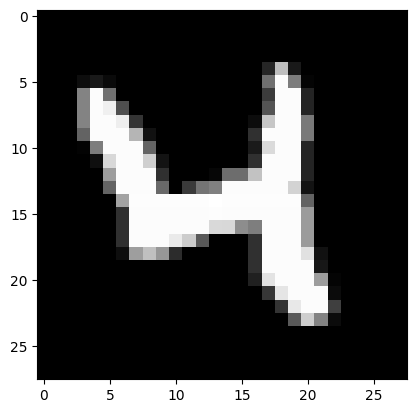

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[20].reshape((28, 28)), cmap="gray")

In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, [x_train, y_train, x_valid, y_valid]
)

x_train.shape

torch.Size([50000, 784])

## Neural Net from Scratch

In [22]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

A tensor has multiple dimensions. There is a forward and backward indexing. Forward indexing uses positive integers, backward indexing uses negative integers.

Example:

- 1 will be the last one, in our case it will be dim=2<br>
- 2 will be dim=1<br>
- 3 will be dim=0<br>

In [23]:
def log_softmax(x):
    # sum(-1) is summing the entire row
    # unsqueeze(-1) adds another dimension "at the end"
    return x - x.exp().sum(-1).log().unsqueeze(-1)


def model(xb):
    return log_softmax(xb @ weights + bias)


"""
We are breaking some autograd mechanics by implementing this function
the following way
"""
# def nll(input, target):
#     # input: tensor with shape (n_samples * 10)
#     # target: tensor with shape (n_samples). Each element in target is in [0, 9]
#     batch_size = target.shape[0]
#     itr = zip(range(batch_size), yb)
#     return -torch.tensor([preds[x, y] for x, y in itr], requires_grad=True).mean()

# this function is extremely unintuitive
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()


def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [25]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2
loss_func = nll
bs = 64  # batch size

for epoch in range(epochs):
    for batch in range(x_train.shape[0] // bs):
        # set_trace()
        start_i = batch * bs
        end_i = start_i + 64

        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]

        preds = model(xb)
        loss = loss_func(preds, yb)

        # this will compute the gradient of the loss function
        # wrt each weight and bias
        loss.backward()

        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            # need to set the gradients to zero otherwise the gradients are added
            weights.grad.zero_()
            bias.grad.zero_()

In [26]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1448, grad_fn=<NegBackward0>) tensor(0.9531)


## Refactored - V1 (torch.nn)

In [29]:
xb = x_train[0:bs]
yb = y_train[0:bs]

In [31]:
import torch.nn.functional as F
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias


model = Mnist_Logistic()
loss_function = F.cross_entropy

print(loss_function(model(xb), yb))

tensor(2.4257, grad_fn=<NllLossBackward0>)


## Refactored - V2 (nn.Linear)

In [38]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)


model = Mnist_Logistic()
cross_entropy_loss = F.cross_entropy

print(cross_entropy_loss(model(xb), yb))

tensor(2.3588, grad_fn=<NllLossBackward0>)


## Refactored - V3 (torch.optim)

In [42]:
from torch import optim


def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(cross_entropy_loss(model(xb), yb))

for epoch in range(epochs):
    for batch in range(x_train.shape[0] // bs):
        start_i = batch * bs
        end_i = start_i + 64
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = cross_entropy_loss(pred, yb)

        loss.backward()
        # no need to manually write the gradient descent step
        opt.step()
        opt.zero_grad()
    print(loss.item())

print(cross_entropy_loss(model(xb), yb))

tensor(2.2948, grad_fn=<NllLossBackward0>)
0.23411674797534943
0.20798861980438232
tensor(0.1438, grad_fn=<NllLossBackward0>)


## Refactored - V4 (TensorDataset)

`Dataset`: An abstract interface of objects with a `__len__` and a `__getitem__`, including classes provided with Pytorch such as `TensorDataset`

`DataLoader`: Takes any `Dataset` and creates an iterator which returns batches of data.

[Tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to create a customer `dataset`

In [43]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

model, opt = get_model()
print(cross_entropy_loss(model(xb), yb))

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = cross_entropy_loss(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
    print(loss.item())

print(cross_entropy_loss(model(xb), yb))

tensor(2.3626, grad_fn=<NllLossBackward0>)
0.23225146532058716
0.2066015899181366
tensor(0.1434, grad_fn=<NllLossBackward0>)


In [44]:
help(model.eval)

Help on method eval in module torch.nn.modules.module:

eval() -> ~T method of __main__.Mnist_Logistic instance
    Set the module in evaluation mode.
    
    This has any effect only on certain modules. See documentations of
    particular modules for details of their behaviors in training/evaluation
    mode, if they are affected, e.g. :class:`Dropout`, :class:`BatchNorm`,
    etc.
    
    This is equivalent with :meth:`self.train(False) <torch.nn.Module.train>`.
    
    See :ref:`locally-disable-grad-doc` for a comparison between
    `.eval()` and several similar mechanisms that may be confused with it.
    
    Returns:
        Module: self

